In [22]:
# =========================
# Import Libraries
# =========================

import pandas as pd, pathlib, joblib, json, datetime, openai, re
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import folium
from folium.plugins import HeatMap
from folium.features import DivIcon
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [23]:
# =========================
# Read CSV File
# =========================

df = pd.read_csv('../data/at-dataset/SCATS-data/Scats-Data-Processed.csv')
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)


# =========================
# Define which detector ID to use
# =========================
detector_id = 2906

df = df[df['Detector_ID'] == detector_id]

le = LabelEncoder()
df['Direction'] = le.fit_transform(df['Direction'])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [24]:
# =========================
# Sample of DF
# =========================

df.head(5)

,Detector_ID,Lane,Volume,Direction
DateTime,,,,
2023-01-01 00:00:00,2906,1,97,1
2023-01-01 01:00:00,2906,1,72,1
2023-01-01 02:00:00,2906,1,27,1
2023-01-01 03:00:00,2906,1,17,1
2023-01-01 04:00:00,2906,1,13,1


In [25]:
# =========================
# Column Info
# =========================

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 185505 entries, 2023-01-01 00:00:00 to 2025-07-31 23:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   Detector_ID  185505 non-null  int64
 1   Lane         185505 non-null  int64
 2   Volume       185505 non-null  int64
 3   Direction    185505 non-null  int64
dtypes: int64(4)
memory usage: 7.1 MB


In [26]:
# =========================
# Functions for plotting traffic volume for each lane
# =========================

def showFigureEachLaneTraffic(df):
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

# =========================
# Functions for plotting traffic volume for each lane for one week
# =========================

def showFigureEachLaneTrafficForOneWeek(df):
    df = df[(df.index > '2024-10-01') & (df.index <= '2024-10-07')]
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

In [27]:
# =========================
# Set sub_df for training and testing
# =========================

sub_df = df
train = sub_df.loc[sub_df.index < '2024-10-01']
test = sub_df.loc[sub_df.index >= '2024-10-01']

In [28]:
# =========================
# Functions for Feature Creation
# =========================

def create_time_features(df):
    df = df.copy().sort_index()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

    # # cyclical encodings
    # df["sin_hour"] = np.sin(2*np.pi*df["hour"]/24)
    # df["cos_hour"] = np.cos(2*np.pi*df["hour"]/24)
    # df["sin_dow"]  = np.sin(2*np.pi*df["dayofweek"]/7)
    # df["cos_dow"]  = np.cos(2*np.pi*df["dayofweek"]/7)

    # # ---- LAGS (hourly)
    # # short-term: 1–12h, daily pattern: 24–25h, multi-day & weekly: 48–168h
    # lags = [1, 2, 3, 6, 12, 24, 25, 48, 72, 168]
    # for L in lags:
    #     df[f"lag_{L}"] = df['Volume'].shift(L)

    # # ---- ROLLING STATS (use shift(1) to avoid leakage)
    # # 3h, 6h, 12h, 24h (1d), 168h (1w)
    # wins = {"3h":3, "6h":6, "12h":12, "1d":24, "1w":168}
    # for name, w in wins.items():
    #     past = df['Volume'].shift(1)
    #     df[f"roll_mean_{name}"] = past.rolling(w).mean()
    #     df[f"roll_max_{name}"]  = past.rolling(w).max()
    #     df[f"roll_std_{name}"]  = past.rolling(w).std()

    return df

In [29]:
# =========================
# Create time features
# =========================

sub_df = create_time_features(sub_df)
train = create_time_features(train)
test  = create_time_features(test)
train = train.dropna()
FEATURES = [
    "Detector_ID","Lane","hour","day","dayofweek","month","year","is_weekend","Direction"
    # "sin_hour","cos_hour","sin_dow","cos_dow",
    # "lag_1","lag_2","lag_3","lag_6","lag_12","lag_24","lag_25","lag_48","lag_72","lag_168",
    # "roll_mean_3h","roll_mean_6h","roll_mean_12h","roll_mean_1d","roll_mean_1w",
    # "roll_max_3h","roll_std_3h"
]
TARGET = 'Volume'

In [30]:
# =========================
# Split data into X and y
# =========================

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [31]:
# =========================
# Check info of X_train
# =========================

X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120489 entries, 2023-01-01 00:00:00 to 2024-09-30 23:00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   Detector_ID  120489 non-null  int64
 1   Lane         120489 non-null  int64
 2   hour         120489 non-null  int32
 3   day          120489 non-null  int32
 4   dayofweek    120489 non-null  int32
 5   month        120489 non-null  int32
 6   year         120489 non-null  int32
 7   is_weekend   120489 non-null  int64
 8   Direction    120489 non-null  int64
dtypes: int32(5), int64(4)
memory usage: 6.9 MB


In [32]:
# =========================
# Model Training with XGBoost
# =========================

reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",            # or "gpu_hist"
    max_depth=8,
    learning_rate=0.05,
    n_estimators=3000,             # high cap; early stopping trims it
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.2,
    reg_alpha=0.0,
    reg_lambda=2.0,
    random_state=42,
    early_stopping_rounds=50,
    enable_categorical=True,     # uncomment if you cast IDs to category & have new XGB
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    # eval_metric="rmse",
    verbose=100
)


# =========================
# save the model with date and time
# =========================

model_save_path = f"../models/xgb-model-{detector_id}-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.json"
reg.save_model(model_save_path)

[0]	validation_0-rmse:142.65746	validation_1-rmse:147.56504
[100]	validation_0-rmse:42.67372	validation_1-rmse:46.81343
[147]	validation_0-rmse:38.02055	validation_1-rmse:48.23378


In [34]:
# =========================
# Feature Importance of the Model
# =========================

reg = xgb.XGBRegressor()
reg.load_model('../models/xgb-model-2906-20251009-163028.json')
pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_).sort_values(by=0, ascending=False)

,0
hour,0.392164
Lane,0.303383
Direction,0.173604
is_weekend,0.055982
dayofweek,0.041616
month,0.012771
day,0.010426
year,0.010055
Detector_ID,0.000000


In [35]:
# =========================
# Make prediction on the test set
# =========================

test['prediction'] = reg.predict(X_test)

In [36]:
# =========================
# Merge prediction with sub_df
# =========================

prediction_df = sub_df.merge(test[['Detector_ID','Lane', 'prediction']], how='left', left_on=['Detector_ID','Lane', sub_df.index], right_on=['Detector_ID','Lane', test.index])
prediction_df.set_index('key_2', inplace=True)
prediction_df.index.name = 'DateTime'

In [37]:
# =========================
# Function for plotting traffic volume with predictions for one week
# =========================

def showTrafficVolumeWithPredictions(df, detector_id, lane):

    start_date = '2025-07-01'
    end_date = '2025-07-08'

    df = df[(df.index > start_date) & (df.index <= end_date) & (df['Lane'] == lane) & (df['Detector_ID'] == detector_id)] 
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.plot(sub_df.index, sub_df['prediction'], '-', label=f'Predictions Lane {lane}')
        ax.set_title(f'Site {detector_id} - Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

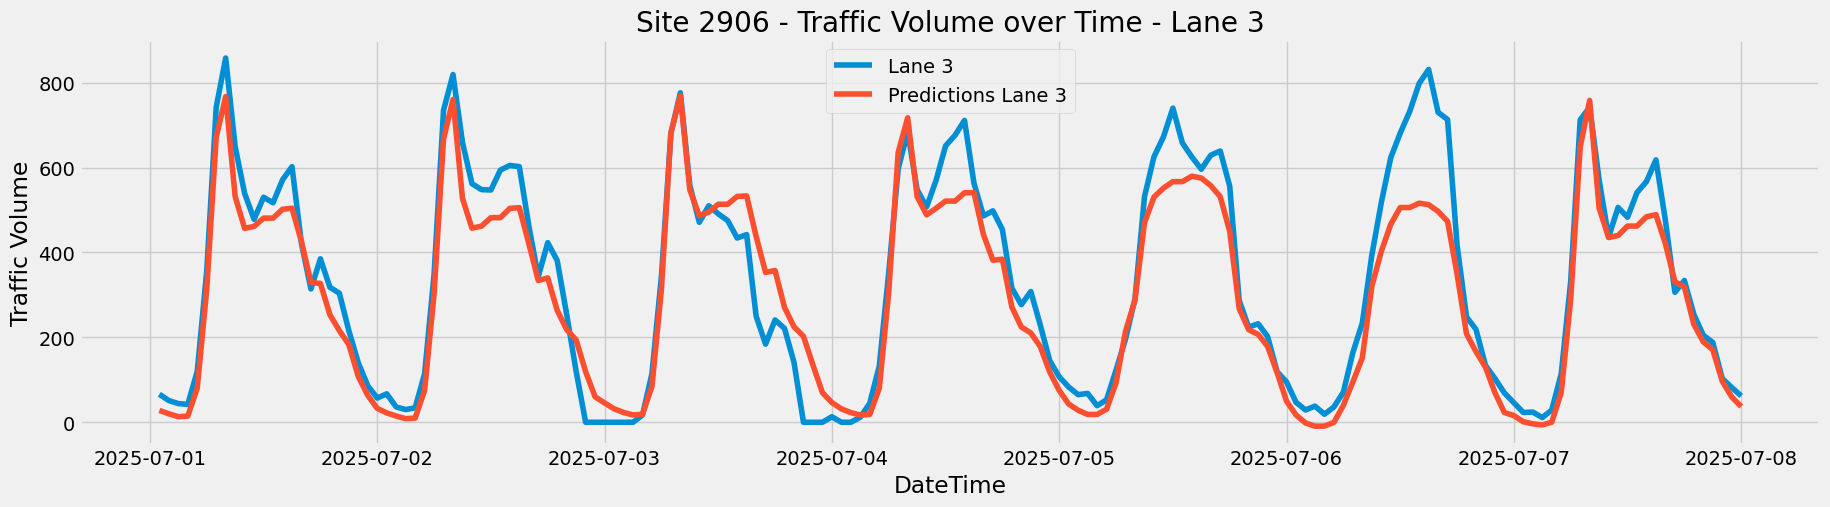

In [38]:
# =========================
# show traffic volume with predictions for one week
# =========================

showTrafficVolumeWithPredictions(prediction_df,2906,3)

In [39]:
# =========================
# Average traffic volume and predictions across all lanes
# =========================

average_traffic = pd.DataFrame()
average_traffic['average_volume'] = prediction_df.groupby(prediction_df.index).mean()['Volume']
average_traffic['average_prediction'] =prediction_df.groupby(prediction_df.index).mean()['prediction']

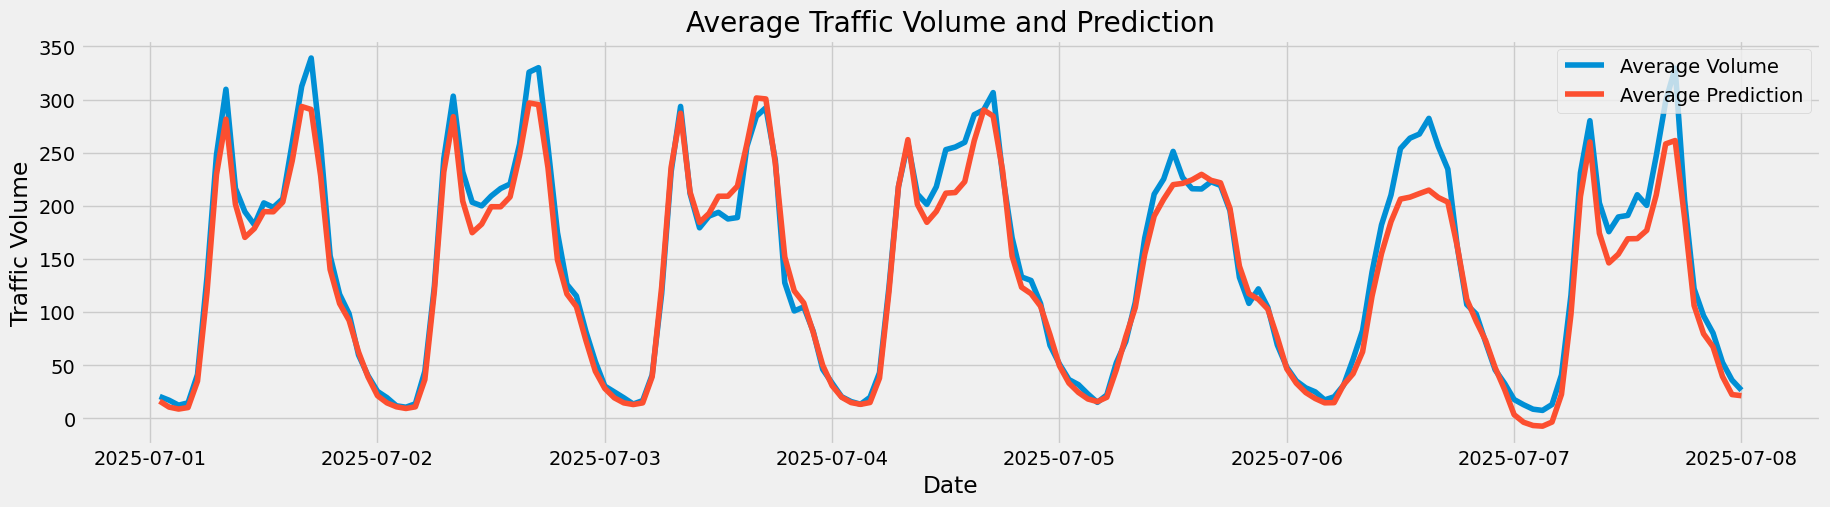

In [40]:
# =========================
# Plot average traffic volume and predictions for one week
# =========================

temp = average_traffic[(average_traffic.index > '2025-07-01') & (average_traffic.index <= '2025-07-08')] 
plt.figure(figsize=(20, 5))
plt.plot(temp.index, temp['average_volume'], label='Average Volume')
plt.plot(temp.index, temp['average_prediction'], label='Average Prediction')
plt.title('Average Traffic Volume and Prediction')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()

In [41]:
# =========================
# Import for SHAP 
# =========================

import shap
# import tqdm as notebook_tqdm

C:\Users\hanju\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
# =========================
# create SHAP explainer
# =========================

background = X_train
explainer = shap.TreeExplainer(reg, feature_perturbation="tree_path_dependent")

# choose a set to explain
X_explain = X_test  # or X_test

# # for speed on big sets, sample
# X_explain_sample = X_explain.sample(min(5000, len(X_explain)), random_state=42)

# SHAP values: returns array (n_samples, n_features)
shap_values = explainer.shap_values(X_explain)
# Expected value (model base value)
base_value = explainer.expected_value

In [66]:
# =========================
# Export SHAP values as CSV
# =========================
from pathlib import Path

outdir = Path.cwd().parent / "results" / "shap_exports" / f"{detector_id}-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
outdir.mkdir(parents=True, exist_ok=True)
df_sv = pd.DataFrame(shap_values, index=X_explain.index,
                     columns=X_explain.columns)

df_sv.to_csv(outdir/"shap_values.csv", index=True)

In [ ]:
prediction_df[prediction_df.index.isin(X_explain.index)][['prediction']].to_csv(outdir/"predictions.csv", index=True, header=['y_hat'])
y_test.loc[X_explain.index].to_csv(outdir/"y_true.csv", index=True, header=['y_true'])
prediction_df[prediction_df.index.isin(X_explain.index)][FEATURES].to_csv(outdir/"features.csv", index=True, header=FEATURES)

import importlib.util

csj_script = Path.cwd().parent / "src" / "convert_shap_json.py"

spec = importlib.util.spec_from_file_location("convert_shap_json", csj_script)
csj = importlib.util.module_from_spec(spec)
spec.loader.exec_module(csj)

csj.build_llm_json(
    shap_csv=outdir/"shap_values.csv",
    features_csv=None,   
    pred_csv=None,            
    ytrue_csv=None,                                     
    units="veh/15min",
    k_top=5,
    out_json=outdir / "shap_values.json",
    out_jsonl=outdir / "shap_values_local.jsonl"
)

Wrote:
- c:\Users\hanju\OneDrive - AUT University\01. Papers\09. Dissertation\4.0 Projects\xai-traffic-prediction\results\shap_exports\2906-20251009-165634\shap_values.json
- c:\Users\hanju\OneDrive - AUT University\01. Papers\09. Dissertation\4.0 Projects\xai-traffic-prediction\results\shap_exports\2906-20251009-165634\shap_values_local.jsonl


In [68]:
# =========================
# Count Traffic in this juntion for the most traffic day
# =========================

most_traffic = prediction_df.copy()
most_traffic['Date'] = most_traffic.index.date
most_traffic['Hour'] = most_traffic.index.hour

peak_hour_traffic = most_traffic[most_traffic['Hour'].isin([7,8,9])]  # Example: Peak hours from 7 AM to 9 AM
peak_hour_counts = peak_hour_traffic.groupby('Date')['Volume'].sum().sort_values(ascending=False)
peak_hour_counts.head(3)

Date
2024-10-04    15781
2024-09-12    15481
2024-09-10    15184
Name: Volume, dtype: int64